# Intuit Quickbooks Upgrade

* Team-lead GitLab userid: mmadhu
* Group name: LuckyDucks
* Team member names: Alexia Pardo Figueroa Dianderas, Madhumita Gowrishankar, Hongyuan Zhang, Lupeng Wang

## Setup

Please complete this python notebook with your group by answering the questions in `intuit-redux.pdf`. Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML file from the Jupyter Notebook without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the second group assignment for MGTA 455 and you will be using Git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". This is not something serious but you should realize that Git will not decide for you who's change to accept so the team-lead will have to determine the edits to use. To avoid merge conflicts, **always** "pull" changes from the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

If multiple people are going to work on the assignment at the same time I recommend you work in different notebooks. You can then `%run ...`  these "sub" notebooks from the main assignment file. You can seen an example of this in action below for the `model1.ipynb` notebook

Some group work-flow tips:

* Pull, edit, save, stage, commit, and push
* Schedule who does what and when
* Try to avoid working simultaneously on the same file 
* If you are going to work simultaneously, do it in different notebooks, e.g., 
    - model1.ipynb, model2.ipynb, model3.ipynb
* Use the `%run ... ` command to bring different pieces of code together into the main jupyter notebook
* Put python functions in modules that you can import from your notebooks. See the example below for the `example` function defined in `utils/functions.py`

A graphical depiction of the group work-flow is shown below:

![](images/git-group-workflow-wbg.png)

Tutorial videos about using Git, GitLab, and GitGadget for group assignments:

* Setup the MSBA server to use Git and GitLab: https://youtu.be/zJHwodmjatY
* Dealing with Merge Conflicts: https://youtu.be/qFnyb8_rgTI
* Group assignment practice: https://youtu.be/4Ty_94gIWeA

In [1]:
# Package Imports 
import numpy as np
import pandas as pd
import pyrsm as rsm
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sms
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn import metrics
# Importing packages for XGboost
from math import sqrt
import graphviz
import xgboost as xgb
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    ShuffleSplit,
    StratifiedShuffleSplit,
)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
## loading the data - this dataset must NOT be changed
data = pd.read_pickle("data/intuit75k.pkl")
data["res1_yes"] = rsm.ifelse(data.res1 == "Yes", 1, 0)
data_train, data_test = data[data.training == 1], data[data.training == 0]
# data.head()

In [3]:
#breakeven
cost = 1.41
margin = 60
breakeven = cost/margin

In [4]:
# show dataset description
rsm.describe(data)

## Intuit: Quickbooks upgrade

The purpose of this exercise is to gain experience modeling the response to an upsell campaign. The `intuit75k.rds` file contains data on 75,000 (small) businesses that were selected randomly from the 801,821 that were sent the wave-1 mailing. The mailing contained an offer to upgrade to the latest version of the Quickbooks software. 

Variable `res1` denotes which of these businesses responded to the mailing by purchasing Quickbooks version 3.0 from Intuit Direct. Note that Intuit Direct sells products directly to its customers rather than through a retailer. Use the available data to predict which businesses that did not respond to the wave-1 mailing, are most likely to respond to the wave-2 mailing. Note that variables were added, deleted, and recoded so please ignore the variable descriptions in Exhibit 3 in the case in the course reader. Instead, use the variable descriptions below:

## Variable description

* id: Small business customer ID
* zip: 5-Digit ZIP Code (00000=unknown, 99999=international ZIPs).
* zip_bins: Zip-code bins (20 approx. equal sized bins from lowest to highest zip code number)
* sex: "Female", "Male", or "Unknown"
* bizflag: Business Flag.  Address contains a Business name (1 = yes, 0 = no or unknown).
* numords: Number of orders from Intuit Direct in the previous 36 months
* dollars: Total $ ordered from Intuit Direct in the previous 36 months
* last: Time (in months) since last order from Intuit Direct in previous 36 months
* sincepurch: Time (in months) since original (not upgrade) purchase of Quickbooks
* version1: Is 1 if customer's current Quickbooks is version 1, 0 if version 2
* owntaxprod: Is 1 if customer purchased tax software, 0 otherwise
* upgraded: Is 1 if customer upgraded from Quickbooks vs. 1 to vs. 2
* res1: Response to wave 1 mailing ("Yes" if responded else "No")
* training: 70/30 split, 1 for training sample, 0 for validation sample


In [5]:
#Making the zip bins as categorical variables
data['zip_bins'] = pd.Categorical(data.zip_bins)

<AxesSubplot:xlabel='zip_bins', ylabel="Proportion of res1_yes equal to '1'">

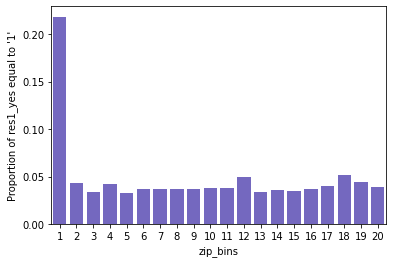

In [6]:
#Zip bins wise response rate
rsm.prop_plot(data, "zip_bins", "res1_yes", 1)

In [7]:
pd.crosstab(data.loc[data.training == 1,"zip"],
           data.loc[data.training == 1,"res1"],
           normalize = "columns",
           ).sort_values("Yes", ascending=False).apply(
lambda x:(100*x).round(2).astype(str) + "%").head(2)

res1,Yes,No
zip,,
00801,19.46%,1.39%
00804,1.8%,0.16%


In [8]:
# Having Zipbins 801 and 804 as separate features
data = data.assign(zip801 = (data.zip == "00801").astype(int),
                  zip804 = (data.zip == "00804").astype(int),
                  )
data_train, data_test = data[data.training == 1], data[data.training == 0]

## Neural Network Model with 1 hidden layer

In [9]:
#Defing the response and explanatory variables
rvar = "res1_yes"
evar = [
   "zip_bins",
    "zip801",
    "zip804",
    "bizflag",
    "numords",
    "dollars",
    "last",
    "sincepurch", 
    "version1",
    "owntaxprod",
    "upgraded"
]
idvar = "id"
lev = "Yes"

In [10]:
X = data[evar].copy()
y = data[rvar]

In [11]:
training = data['training']

In [12]:
#Categorizing columns
X["version1"] = X["version1"].astype(str)
X["owntaxprod"] = X["owntaxprod"].astype(str)
X["upgraded"] = X["upgraded"].astype(str)
X["bizflag"] = X["bizflag"].astype(str)
X["zip801"] = X["zip801"].astype(str)
X["zip804"] = X["zip804"].astype(str)


By passing information about the training variable to `rsm.scale_df` the variables will be scaled using *only* information from the training sample and you will retain the column headers

In [13]:
#Scaling and standardizing the numeric variables
Xs = rsm.scale_df(X, train=data.training == 1, excl= "training") #["sex", "version1", 'owntaxprod', 'upgrade'])

In [14]:
#Defining Neural Network with 1 hidden layer (instead of logistic regression)
clf = MLPClassifier(
    activation="relu",
    solver="lbfgs",
    alpha=0.001,
    hidden_layer_sizes=(1,),
    random_state=1234,
    max_iter=10000,
).fit(Xs[training == 1], y[training == 1])

In [15]:
#Creating eval_data to store eval_bin outputs
eval_dat = data[[idvar, rvar]].copy()
eval_dat["training"] = data["training"]

In [16]:
#Predicting probablities using neural network with one hidden layer
eval_dat["y_nn_1"] = clf.predict_proba(Xs)[:, 1]

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [17]:
#eval bin results
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
rsm.evalbin(
    dct, "res1_yes", 1, ["y_nn_1"], cost= cost, margin= margin
)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_nn_1,2192,29619,20383,306,52500,0.878,0.408,0.069,0.128,0.430,0.043,86666.49,1.0,1.932,0.606,0.766
1,test,y_nn_1,964,12823,8574,139,22500,0.874,0.401,0.070,0.129,0.424,0.043,38400.33,1.0,1.975,0.613,0.765


In [18]:
# Predictions for test and train separately 
pred_train_nn1 = pd.DataFrame().assign(
    actual=y[training == 1], pred=clf.predict_proba(X[training == 1])[:, 1]
)
pred_test_nn1 = pd.DataFrame().assign(actual=y[training == 0], pred=clf.predict_proba(X[training == 0])[:, 1])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


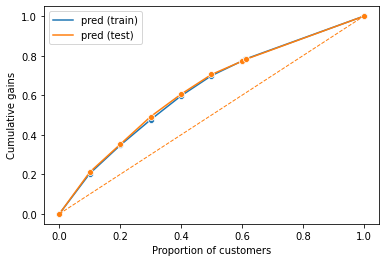

In [19]:
dct = {"train": pred_train_nn1, "test": pred_test_nn1}
fig = rsm.gains_plot(dct, "actual", 1, "pred")
fig = fig.legend(title=None)

## Neural Network Model with 2 hidden layers

In [20]:
#Standardized data 
data_std = rsm.scale_df(data, excl=["res1_yes", "training", "res1", "id", "zip", "bizflag","version1", "owntaxprod", "upgraded", "zip801", "zip804"])
X = pd.concat(
    [
        pd.get_dummies(data_std[["zip_bins", "sex"]], drop_first=True),
        data_std[["bizflag", "numords", "dollars", "last", "sincepurch", "version1", "owntaxprod", "upgraded", "zip801", "zip804"]],
    ],
    axis=1,
)
y = data.res1_yes

In [21]:
#Defining Neural Network and feature importance functions
def nn(X, y, hlsizes=(1,), alpha=0.001, max_iter=1000):
    return MLPClassifier(
        activation="relu",
        solver="lbfgs",
        hidden_layer_sizes=hlsizes,
        alpha=alpha,
        random_state=1234,
        max_iter=max_iter,
    ).fit(X, y)

def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    if cn is not None:
        data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig

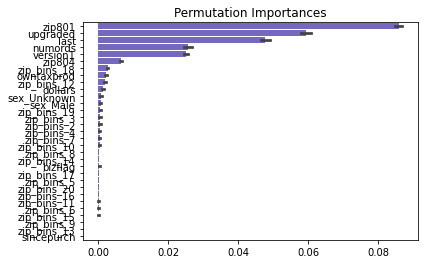

In [22]:
#Predicting based on 2 layer neural network
clf = nn(X[training == 1], y[training == 1], hlsizes=(2,))
data_std["pred_nn2"] = clf.predict_proba(X)[:, 1]
eval_dat["pred_nn2"]= clf.predict_proba(X)[:, 1]
fig = importance(clf, X[training == 1], y[training == 1], X[training == 1].columns)

In [23]:
#Eval bin for neural network with 2 hidden layers
rsm.evalbin(eval_dat[eval_dat.training == 0], "res1_yes", 1, "pred_nn2", cost= cost, margin= margin, dec=6)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,pred_nn2,957,12406,8991,146,22500,0.867634,0.420199,0.071616,0.13231,0.442133,0.045898,38578.17,1.0,2.047475,0.593911,0.766386


In [24]:
# Predictions for test and train separately 
pred_train_nn2 = pd.DataFrame().assign(
    actual=y[training == 1], pred=clf.predict_proba(X[training == 1])[:, 1]
)
pred_test_nn2 = pd.DataFrame().assign(actual=y[training == 0], pred=clf.predict_proba(X[training == 0])[:, 1])

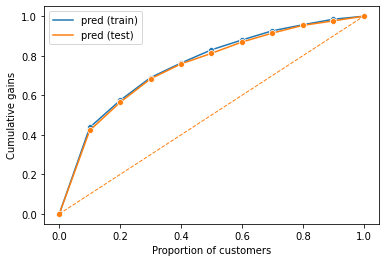

In [25]:
dct = {"train": pred_train_nn2, "test": pred_test_nn2}
fig = rsm.gains_plot(dct, "actual", 1, "pred")
fig = fig.legend(title=None)

In [26]:
#Fine tuning paramters for neural network
hls = [(2,), (3,)]
clf = nn(X[training == 1], y[training == 1], (1,))

param_grid = {"hidden_layer_sizes": hls}
scoring = {"AUC": "roc_auc"}

clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
)
clf_cv.fit(X[training == 1], y[training == 1])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0.001, hidden_layer_sizes=(1,),
                                     max_iter=1000, random_state=1234,
                                     solver='lbfgs'),
             n_jobs=4, param_grid={'hidden_layer_sizes': [(2,), (3,)]},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

In [27]:
# Best parameters selected after fine tuning
clf_cv.best_params_

{'hidden_layer_sizes': (2,)}

## Neural Network Model with 3 hidden layers

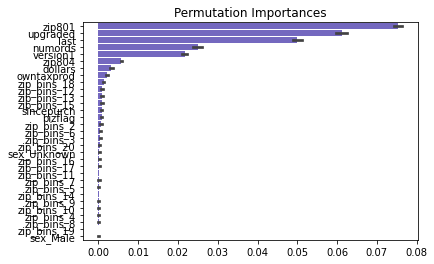

In [28]:
# Neural Network for 3 hidden layers
clf = nn(X[training == 1], y[training == 1], hlsizes=(3,))
eval_dat["pred_nn3"]= clf.predict_proba(X)[:, 1]
fig = importance(clf, X[training == 1], y[training == 1], X[training == 1].columns)

In [29]:
#eval bin for neural network with 3 hidden layers
rsm.evalbin(eval_dat[eval_dat.training == 0], "res1_yes", 1, "pred_nn3", cost= cost, margin= margin, dec=6)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,pred_nn3,937,11661,9736,166,22500,0.849501,0.455017,0.074377,0.136778,0.474356,0.051247,38456.82,1.0,2.164974,0.559911,0.76493


In [30]:
#Prediction based on neural network with 3 hidden layers
pred_train_nn3 = pd.DataFrame().assign(
    actual=y[training == 1], pred=clf.predict_proba(X[training == 1])[:, 1]
)
pred_test_nn3 = pd.DataFrame().assign(actual=y[training == 0], pred=clf.predict_proba(X[training == 0])[:, 1])

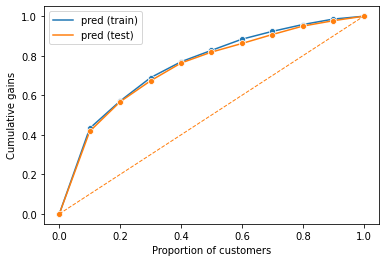

In [31]:
dct = {"train": pred_train_nn3, "test": pred_test_nn3}
fig = rsm.gains_plot(dct, "actual", 1, "pred")
fig = fig.legend(title=None)

## XGBoost

In [32]:
## Copying data in dataframe data 
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
data = intuit75k[['zip','zip_bins','numords','dollars','last','version1','owntaxprod','upgraded','res1','training','res1_yes','sincepurch','bizflag','sex']].copy()

In [33]:
data = data.assign(zip801 = (data.zip == "00801").astype(int),
                  zip804 = (data.zip == "00804").astype(int),
                  )

In [34]:
#Converting the required explanatory variables to category
data["zip_bins"] = data["zip_bins"].astype('category')
data["version1"] = data["version1"].astype('category')
data["owntaxprod"] = data["owntaxprod"].astype('category')
data["upgraded"] = data["upgraded"].astype('category')
data['zip801'] = data['zip801'].astype('category')
data['zip804'] = data['zip804'].astype('category')
data['sex'] = data['sex'].astype('category')
data['bizflag'] = data['bizflag'].astype('category')

In [35]:
#Selecting variables to standardize
to_std = data.columns[[pd.api.types.is_numeric_dtype(data[col]) for col in data.columns]]
to_std = rsm.setdiff(to_std, ["training", "res1_yes","id"])

In [36]:
#Standardizing the required variables
data_std = data.copy()
data_std[to_std] = rsm.scale_df(data_std[to_std], sf=1, train=data_std.training == 1)

In [37]:
#Choosing the required explanatory variables for the model
X = pd.concat(
    [
        pd.get_dummies(data_std[["zip_bins", "version1", "owntaxprod", "zip801",'zip804', "upgraded",'sex','bizflag']], drop_first=True),
        data_std["numords"],
        data_std["last"],
        data_std["dollars"],        
        data_std['sincepurch']        
    ],
    axis=1,
)
y = data_std.res1_yes

In [38]:
#Basic XG boost model without fine tuning the hyperparameters
clf = xgb.XGBClassifier(
    max_depth=3,
    n_estimators=100,
    objective="binary:logistic",
    use_label_encoder=False,
    early_stopping_rounds=10,
    eval_metric="auc",
    random_state=1234,
).fit(X[data_std['training'] == 1], y[data_std['training'] == 1], verbose=True)

[21:43:57] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [39]:
#Prediction using the basic XG boost model
data_std["y_xgb"] = clf.predict_proba(X)[:, 1]

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [40]:
# XGBoost with cross-validation and grid search
clf = xgb.XGBClassifier()
param_grid = {
    "learning_rate" : [0.1], #(0.01,0.1,0.5), 
    "max_depth": [3], # list(range(1, 5)),
    "n_estimators": [100] #list(range(100,301,100))
}
scoring = {"AUC": "roc_auc"}

In [41]:
#Finetuning the XG boost model with GridSearch
clf_cv_xgb = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(X[data_std['training'] == 1], y[data_std['training'] == 1])#early_stopping_rounds=10

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:44:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [42]:
#Getting the best tuned hyperparameters with the best AUC
print(clf_cv_xgb.best_params_)
print(clf_cv_xgb.best_score_)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.770876683868046


In [43]:
#Prediction using the tuned XGboost
data_std["y_xgb_cv"] = clf_cv_xgb.predict_proba(X)[:, 1]
eval_dat["y_xgb_cv"] = clf_cv_xgb.predict_proba(X)[:, 1]

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [44]:
# Predictions for test and train separately 
pred_train_xgb = pd.DataFrame().assign(
    actual=y[training == 1], pred=clf_cv_xgb.predict_proba(X[training == 1])[:, 1]
)
pred_test_xgb = pd.DataFrame().assign(actual=y[training == 0], pred=clf_cv_xgb.predict_proba(X[training == 0])[:, 1])

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


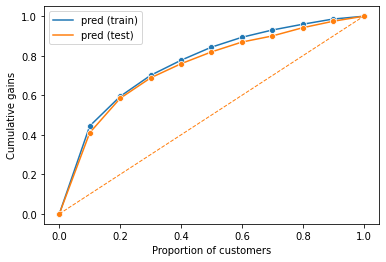

In [45]:
dct = {"train": pred_train_xgb, "test": pred_test_xgb}
fig = rsm.gains_plot(dct, "actual", 1, "pred")
fig = fig.legend(title=None)

## Model Evaluation

In [59]:
#Eval bins for all the models

dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
}
rsm.evalbin(
    dct, "res1_yes", 1, ["y_nn_1", "pred_nn2", "pred_nn3", "y_xgb_cv"], cost= cost, margin= margin
)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_nn_1,2192,29619,20383,306,52500,0.878,0.408,0.069,0.128,0.430,0.043,86666.49,0.969,1.932,0.606,0.766
1,training,pred_nn2,2188,28804,21198,310,52500,0.876,0.424,0.071,0.131,0.445,0.047,87581.28,0.980,2.004,0.590,0.775
2,training,pred_nn3,2158,27169,22833,340,52500,0.864,0.457,0.074,0.136,0.476,0.053,88128.93,0.986,2.131,0.559,0.776
3,training,y_xgb_cv,2210,28431,21571,288,52500,0.885,0.431,0.072,0.133,0.453,0.050,89396.19,1.000,2.069,0.584,0.786
4,test,y_nn_1,964,12823,8574,139,22500,0.874,0.401,0.070,0.129,0.424,0.043,38400.33,0.993,1.975,0.613,0.765
5,test,pred_nn2,957,12406,8991,146,22500,0.868,0.420,0.072,0.132,0.442,0.046,38578.17,0.998,2.047,0.594,0.766
6,test,pred_nn3,937,11661,9736,166,22500,0.850,0.455,0.074,0.137,0.474,0.051,38456.82,0.995,2.165,0.560,0.765
7,test,y_xgb_cv,956,12301,9096,147,22500,0.867,0.425,0.072,0.133,0.447,0.047,38667.63,1.000,2.069,0.589,0.767


In [60]:
eval_dat

,id,res1_yes,training,y_nn_1,pred_nn2,pred_nn3,y_xgb_cv
0,1,0,1,0.033679,0.046064,0.041151,0.036557
1,2,0,0,0.024696,0.025522,0.023382,0.031443
2,3,0,0,0.090177,0.083554,0.081208,0.079371
3,4,0,1,0.012317,0.009194,0.016504,0.015983
4,5,0,0,0.025815,0.027056,0.027103,0.027954
...,...,...,...,...,...,...,...
74995,74996,1,1,0.058752,0.050740,0.042332,0.058000
74996,74997,0,1,0.013931,0.008904,0.014468,0.009405
74997,74998,0,1,0.056422,0.050674,0.037948,0.062962
74998,74999,0,1,0.033329,0.047075,0.039942,0.045685


In [61]:
eval_dat.to_csv("eval_dat.csv")

In [62]:
result_dat = eval_dat[['id', "res1_yes", "training", "y_nn_1", "pred_nn2", "pred_nn3",  "y_xgb_cv"]]

In [63]:
#Creating the ensemble model with 80% weightage to neural network with 2 hidden layers and xgboost (top 2 best performing models)
result_dat["pred_ensemble"] = result_dat["pred_nn2"]*0.8 + result_dat["y_xgb_cv"]*0.1 + result_dat["y_nn_1"]*0.1

In [64]:
dct = {
    "training": result_dat[result_dat.training == 1],
    "test": result_dat[result_dat.training == 0],
}
rsm.evalbin(
    dct, "res1_yes", 1, [ "y_nn_1", "pred_nn2", "pred_nn3", "y_xgb_cv", "pred_ensemble"], cost= cost, margin= margin
)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_nn_1,2192,29619,20383,306,52500,0.878,0.408,0.069,0.128,0.430,0.043,86666.49,0.969,1.932,0.606,0.766
1,training,pred_nn2,2188,28804,21198,310,52500,0.876,0.424,0.071,0.131,0.445,0.047,87581.28,0.980,2.004,0.590,0.775
2,training,pred_nn3,2158,27169,22833,340,52500,0.864,0.457,0.074,0.136,0.476,0.053,88128.93,0.986,2.131,0.559,0.776
3,training,y_xgb_cv,2210,28431,21571,288,52500,0.885,0.431,0.072,0.133,0.453,0.050,89396.19,1.000,2.069,0.584,0.786
4,training,pred_ensemble,2199,29018,20984,299,52500,0.880,0.420,0.070,0.130,0.442,0.046,87924.03,0.984,1.998,0.595,0.777
5,test,y_nn_1,964,12823,8574,139,22500,0.874,0.401,0.070,0.129,0.424,0.043,38400.33,0.993,1.975,0.613,0.765
6,test,pred_nn2,957,12406,8991,146,22500,0.868,0.420,0.072,0.132,0.442,0.046,38578.17,0.998,2.047,0.594,0.766
7,test,pred_nn3,937,11661,9736,166,22500,0.850,0.455,0.074,0.137,0.474,0.051,38456.82,0.995,2.165,0.560,0.765
8,test,y_xgb_cv,956,12301,9096,147,22500,0.867,0.425,0.072,0.133,0.447,0.047,38667.63,1.000,2.069,0.589,0.767
9,test,pred_ensemble,960,12512,8885,143,22500,0.870,0.415,0.071,0.132,0.438,0.045,38604.48,0.998,2.032,0.599,0.767


In [65]:
# Determining Mailto customers for wave 2
result_dat["mailto_wave2"] = (result_dat['pred_ensemble']*0.5)> (breakeven)
result_dat['mailto_wave2'][result_dat['res1_yes']==1] = False

<ipython-input-65-ed715e402037>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_dat['mailto_wave2'][result_dat['res1_yes']==1] = False


In [66]:
len(result_dat[(result_dat['training']==0) & (result_dat["mailto_wave2"]==True)])

6040

In [67]:
output = result_dat[(result_dat['training']==0)][['id','mailto_wave2']].set_index('id')
output['mailto_wave2']=rsm.ifelse(output['mailto_wave2']==True,'TRUE','FALSE')

In [68]:
#Exporting the ouput to csv
output.to_csv('Alexia_Hongyuan_Lupeng_Madhumita_LuckyDucks.csv')

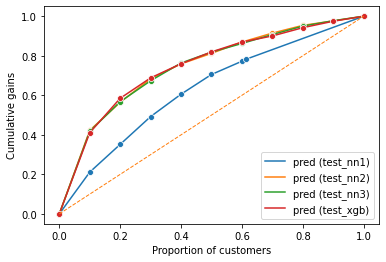

In [84]:
# testing set gains plot
dct = {"test_nn1": pred_test_nn1, "test_nn2": pred_test_nn2, "test_nn3": pred_test_nn3, "test_xgb": pred_test_xgb}
fig = rsm.gains_plot(dct, "actual", 1, "pred")
fig = fig.legend(title=None)

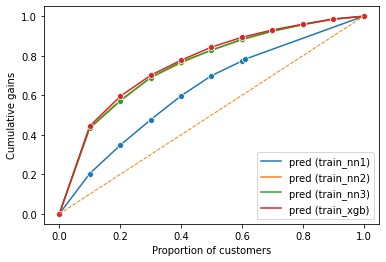

In [86]:
# training set gains plot
dct = {"train_nn1": pred_train_nn1, "train_nn2": pred_train_nn2, "train_nn3": pred_train_nn3, "train_xgb": pred_train_xgb}
fig = rsm.gains_plot(dct, "actual", 1, "pred")
fig = fig.legend(title=None)